In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

## List of High Fashion Brands

In [3]:
import requests

def retrieve(cat_name, mw_instance='https://en.wikipedia.org', types=['page', 'subcat', 'file'], clean_subcat_names=False):
    """Retrieve pages that belong to a given category.
        Args:
            cat_name: Category name e.g. 'Category:Presidents_of_the_United_States'.
            mw_instance: Which MediaWiki instance to use (the URL 'origin'). Defaults to 'https://en.wikipedia.org'.
            types: Which types of pages to retrieve. Defaults to `['page', 'subcat', 'file']`.
            clean_subcat_names: If `True`, removes the e.g. 'Category:' prefix of the titles. Defaults to `False`.
        Returns:
            Array of pages where a page is a dictionary of `{'name': 'some name', 'link': 'some absolute link'}`.
    """
    cmtype = f'&cmtype={"|".join(types)}'
    base_url = f'{mw_instance}/w/api.php?action=query&format=json&list=categorymembers&cmtitle={cat_name}&cmlimit=500{cmtype}'
    cont = ''

    result = []

    while True:
        url = f'{base_url}&cmcontinue={cont}'
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        r_json = r.json()

        if 'query' in r_json:
            for item in r_json['query']['categorymembers']:
                title = item['title']
                if clean_subcat_names and ':' in title:
                    # cut away ':' and evertyhing before
                    index_sep = title.index(':')
                    title = title[index_sep + 1:]
                # spaces need to be converted in links
                link = f'{mw_instance}/wiki/{title.replace(" ", "_")}'
                result.append({'name': title, 'link': link})

        if 'continue' not in r_json:
            break
        else:
            cont = r_json['continue']['cmcontinue']

    return result

In [4]:
results = retrieve('Category:High fashion brands', types = ['page'])
high_fashion_brands = [elem['name'] for elem in results]
print(f"Found {len(high_fashion_brands)} pages")

Found 424 pages


In [5]:
import re
def clean_brand(brand):
    brand = re.sub("[\(\[].*?[\)\]]", "", brand)
    return brand.strip()

high_fashion_brands = [clean_brand(brand) for brand in high_fashion_brands]

## Zalando Dataset

In [6]:
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
meta.original_price = pd.to_numeric(meta.original_price, errors='coerce')
brands = list(meta.brand.unique())
meta.head(3)


,sku,name,sku_base,sku_color_code,url,brand,original_price,current_price,brand_url,category,...,fabric,fit,neckline,pattern,collar,length,shape,sleeve_length,thumbnail_url,packshot_url
0,AN621C22S-O11,Jersey dress - brown,AN621C22S,O11,https://en.zalando.de/anna-field-shift-dress-b...,Anna Field,39.99,39.99,https://en.zalando.de/anna-field/,Shift dress,...,Jersey,Slim Fit,None,Plain,Standing collar,Calf-length,Body-hugging,Short,https://img01.ztat.net/article/spp-media-p1/fb...,https://img01.ztat.net/article/spp-media-p1/c8...
1,BU321C01G-K11,Jersey dress - marine/bedruckt,BU321C01G,K11,https://en.zalando.de/buffalo-jersey-dress-mar...,Buffalo,39.99,39.99,https://en.zalando.de/buffalo/,Jersey dress,...,Jersey,Regular Fit,Low-cut v-neck,Print,None,Knee-length,Fitted,Sleeveless,https://img01.ztat.net/article/spp-media-p1/50...,https://img01.ztat.net/article/spp-media-p1/17...
2,JY121C0TB-A11,JDYCARLA CATHINKA DRESS - Jersey dress - cloud...,JY121C0TB,A11,https://en.zalando.de/jdy-carla-cathinka-dress...,JDY,34.99,34.99,https://en.zalando.de/jacqueline-de-yong/,Jersey dress,...,None,Regular Fit,Crew neck,Plain,Standing collar,Knee-length,Flared,Short,https://img01.ztat.net/article/spp-media-p1/20...,https://img01.ztat.net/article/spp-media-p1/20...


In [7]:
# # Plot distribution of prices
# sns.kdeplot(meta['original_price'], fill=True)
# plt.title('Distribution of original prices')
# plt.xlabel('Price in €')
# plt.ylabel('Density')
# plt.show()
# meta.original_price.describe()

### Match Brands against High Fashion Brands List

In [8]:
elem = brands[0]

In [9]:
from thefuzz import process

matches = {}
for brand in brands: 
    match, score = process.extractOne(brand, high_fashion_brands)
    if score > 90:
        matches[brand] = match
    else: 
        matches[brand] = None

df = pd.DataFrame(matches.items(), columns=['Brand', 'Match'])
df[df.Match.notna()]

,Brand,Match
10,LIU JO,Liu Jo
32,Lauren Ralph Lauren,Ralph Lauren Corporation
43,MM6 Maison Margiela,Maison Margiela
70,Tommy Hilfiger,Tommy Hilfiger
74,Pinko,Pinko
88,Diane von Furstenberg,Diane von Fürstenberg
90,Calvin Klein,Calvin Klein
121,Paul Smith,Paul Smith
142,Tommy Hilfiger Curve,Tommy Hilfiger
205,Halston,Halston


In [10]:
meta['is_luxury'] = meta['brand'].isin([k for k,v in matches.items() if v is not None])


### Try Luxury Classification based on Price

In [11]:
brand_means = meta.groupby('brand').original_price.mean()
for elem in [100, 200, 300, 400, 500]:
    print(f"Number of brands with mean price > {elem}: {len(brand_means[brand_means > elem])}")

Number of brands with mean price > 100: 375
Number of brands with mean price > 200: 184
Number of brands with mean price > 300: 115
Number of brands with mean price > 400: 72
Number of brands with mean price > 500: 54


In [12]:
meta['is_luxury'] = np.where(meta.original_price > 200, True, False)
meta.is_luxury.value_counts()

is_luxury
False    11272
True      2788
Name: count, dtype: int64

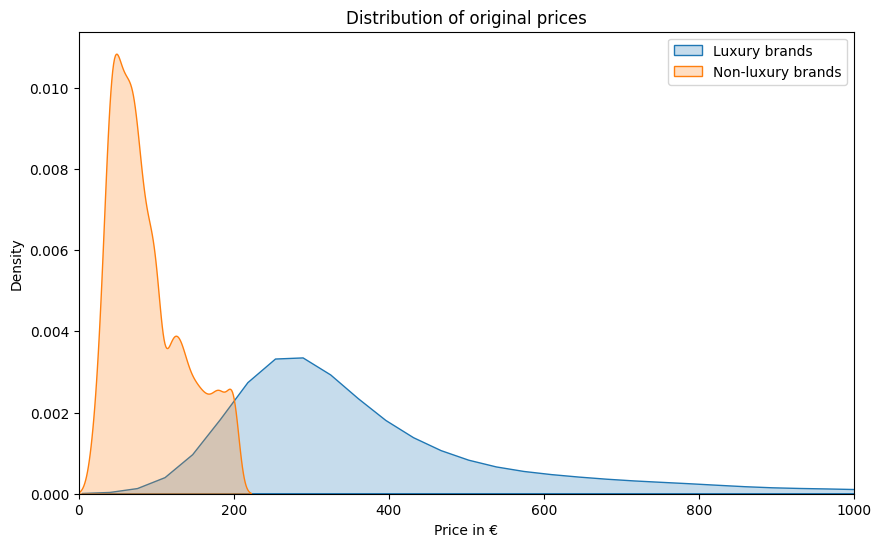

In [13]:
# Plot the two distributions
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(meta[meta.is_luxury == True].original_price, fill=True, ax=ax, label='Luxury brands')
sns.kdeplot(meta[meta.is_luxury == False].original_price, fill=True, ax=ax, label='Non-luxury brands')
plt.title('Distribution of original prices')
plt.xlabel('Price in €')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000)
plt.show()

### Brands

- Subset metadata to include only brands that have more than 80 images in the dataset.
- Check homogeneity of images within each brand. A more homogeneous brand might have a higher brand identity in their designs
- Check distance of each brand to any other brand. Brands that are more distant from each other might be easier to learn linear boundaries for.
- All checks performed using DinoV2 embeddings.

In [14]:
counts = meta.brand.value_counts().sort_values(ascending=False)
subset_brands = list(counts[counts > 80].index)
meta = meta[meta.brand.isin(subset_brands)]

In [15]:
# Load Dino Embeddings
embeddings = torch.load(f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/real_images_embeddings.pt")
embeddings = {k:v for k,v in embeddings.items() if k in meta.sku.values}

In [16]:
# Calculate the mean and distance to mean of dino embeddings for each brand
brand_means = {}
mean_distances = {}

for brand in subset_brands:
    skus = meta[meta.brand == brand].sku
    brand_embeddings = torch.stack([embeddings[sku].squeeze(0) for sku in skus])
    centroid = brand_embeddings.mean(dim=0)
    brand_means[brand] = centroid

    distances = torch.norm(brand_embeddings - centroid, dim=1)
    mean_distances[brand] = distances.mean().item()

pd.DataFrame(mean_distances.items(), columns=['Brand', 'Mean Distance to centroid']).sort_values('Mean Distance to centroid', ascending=False)

,Brand,Mean Distance to centroid
37,Superdry,34.981808
22,Mango,34.536495
18,YAS,33.168816
25,faina,33.101345
26,Morgan,32.836922
28,Bershka,32.831516
0,Next,32.717041
16,Guess,32.459114
2,Vero Moda,31.805344
20,Anna Field,31.790676


In [17]:
# Calculate which brand means are most and least similar to each other 
from scipy.spatial.distance import pdist, squareform

brand_means = torch.stack([v for k,v in brand_means.items()])
distances = pdist(brand_means, metric='cosine')
distances = squareform(distances)

distances = pd.DataFrame(distances, index=subset_brands, columns=subset_brands)
distances

,Next,VILA,Vero Moda,Ulla Popken,Esprit,Kaffe,Vera Mont,Swing,ONLY,Kraimod,...,Bershka,Fransa,Culture,BOSS,Cream,Even&Odd,Noppies,s.Oliver BLACK LABEL,ICHI,Superdry
Next,0.000000,0.208597,0.202724,0.217241,0.299802,0.229498,0.290905,0.301550,0.205806,0.314101,...,0.170693,0.286245,0.236393,0.310730,0.192741,0.385043,0.433145,0.318584,0.207865,0.105422
VILA,0.208597,0.000000,0.016071,0.064379,0.050372,0.056845,0.099262,0.129135,0.022632,0.119376,...,0.237868,0.049091,0.101746,0.049020,0.062587,0.158949,0.129223,0.050188,0.039088,0.239590
Vero Moda,0.202724,0.016071,0.000000,0.045177,0.043702,0.036086,0.138641,0.175215,0.019362,0.151960,...,0.248163,0.036612,0.070902,0.053347,0.033432,0.167642,0.135990,0.053987,0.025766,0.238886
Ulla Popken,0.217241,0.064379,0.045177,0.000000,0.056934,0.020865,0.148959,0.194439,0.051766,0.176184,...,0.269637,0.035821,0.058714,0.084271,0.048099,0.205559,0.162056,0.066699,0.033470,0.241761
Esprit,0.299802,0.050372,0.043702,0.056934,0.000000,0.057004,0.139502,0.194549,0.049989,0.148477,...,0.245384,0.034382,0.114107,0.039398,0.095827,0.107789,0.081044,0.043428,0.069553,0.251111
Kaffe,0.229498,0.056845,0.036086,0.020865,0.057004,0.000000,0.182968,0.227619,0.051433,0.209505,...,0.277333,0.026374,0.043170,0.079310,0.040011,0.199374,0.153054,0.064069,0.023209,0.256011
Vera Mont,0.290905,0.099262,0.138641,0.148959,0.139502,0.182968,0.000000,0.022238,0.098134,0.022173,...,0.247146,0.179097,0.247447,0.115785,0.186607,0.188280,0.203735,0.120663,0.151985,0.282253
Swing,0.301550,0.129135,0.175215,0.194439,0.194549,0.227619,0.022238,0.000000,0.137747,0.034667,...,0.305832,0.229535,0.282766,0.174430,0.212715,0.260094,0.262344,0.176938,0.186633,0.326799
ONLY,0.205806,0.022632,0.019362,0.051766,0.049989,0.051433,0.098134,0.137747,0.000000,0.113811,...,0.224744,0.056857,0.106272,0.059751,0.053701,0.158370,0.138133,0.048786,0.034311,0.228168
Kraimod,0.314101,0.119376,0.151960,0.176184,0.148477,0.209505,0.022173,0.034667,0.113811,0.000000,...,0.263103,0.196631,0.268397,0.129408,0.198920,0.184630,0.203314,0.139625,0.172585,0.293362
